
# **Implementation & Explanation — Distributed MLP (PyTorch DDP + Optional Horovod)**

## **Summary**
This notebook implements a distributed mini-batch MLP for MNIST using **PyTorch Distributed Data Parallel (DDP)** and, optionally, **Horovod**.  
While Horovod is kept as a reference for comparison, it is **disabled by default** in Google Colab due to installation complexity and limited multi-GPU support in this environment.

The implementation demonstrates system-level trade-offs in distributed machine learning — particularly data parallelism, synchronization, and GPU acceleration.

---

## **Environment & Assumptions**
- Target runtime: **Google Colab** with **NVIDIA Tesla T4 GPU**
- Python ≥ 3.10, PyTorch ≥ 2.0
- Single GPU (simulated multi-worker training possible via DDP with `world_size > 1`)
- MNIST dataset loaded via `torchvision.datasets`
- CUDA 11.x & cuDNN provided by Colab

---

## **High-level design choices**
- **Parallelism type**: Data Parallelism  
- **Backend**: DDP (`torch.distributed`), Horovod (optional reference)
- **Batch handling**: `DistributedSampler` ensures disjoint mini-batches per worker
- **Synchronization**:
  - DDP: Automatic gradient sync during backward pass
  - Horovod: Explicit optimizer wrapping + broadcast parameters
- **Checkpointing**: Only rank 0 saves model & training metrics

---

## **Data pipeline**
- **Transforms**: Normalize MNIST images, convert to tensor
- **DataLoader**: Uses `DistributedSampler` when `world_size > 1`
- **Shuffling**: Epoch-based via `set_epoch()` for reproducibility

---

## **Model**
- Architecture: MLP with 2–3 hidden layers, ReLU activations, Dropout regularization
- Fully connected layers for **28×28 input → output classes 0–9**

---

## **Optimization & synchronization**
- Optimizer: **SGD** (learning rate scaling possible for Horovod)
- Loss function: **CrossEntropyLoss**
- DDP: Gradient sync happens automatically during backward()
- Horovod: `hvd.DistributedOptimizer` wraps the optimizer

---

## **Training loop (each epoch)**
1. Set `model.train()`  
2. For each batch:  
   - Forward pass  
   - Compute loss  
   - Backward pass (**DDP sync here**)  
   - Optimizer step  
3. Record metrics: loss, accuracy, epoch time  
4. Validate (rank 0 only)  
5. Store metrics for plotting

---

## **Communication timing & diagnostics**
- `epoch_time` recorded
- Optional: explicit timing of `all_reduce` for comm_time measurement
- GPU memory usage can be checked

---

## **Plots & outputs included**
- **Loss curves**: Train vs Validation  
- **Accuracy curves**: Train vs Validation  
- **Epoch time chart**: Per-epoch training time

---

## **Differences between Horovod and DDP (concise)**
- **DDP**: Built into PyTorch, gradient sync hooks, backend options (NCCL/Gloo)
- **Horovod**: External library, optimizer wrapping, explicit broadcast of parameters

---

## **How to run notebook**
1. Enable GPU in Colab runtime  
2. Run **Environment setup** cell  
3. Run **DDP training demo** (`run_ddp_demo(...)`)  
4. Plot results using `plot_history(...)`  
5. *(Optional)* Try Horovod example after installing Horovod

---

## **Limitations & observed challenges**
- Colab has single GPU → can't measure true multi-GPU bandwidth
- Horovod install may fail on Colab
- Epoch timing includes both compute & communication
- Dataset is small → comm overhead minimal

---

## **Why Horovod is Optional**
Horovod is kept only for **educational comparison** to DDP.  
Reasons for disabling it by default in Colab:
1. Installation takes 5–10 minutes and may fail due to version conflicts.
2. No real performance gain on single GPU.
3. DDP is natively supported in PyTorch and faster to set up.



# Distributed Mini-Batch MLP — MNIST (Clean, Unified)
**Author:** Rahul Agarwal (updated)


This notebook provides a clean, unified implementation for distributed mini-batch training of an MLP on MNIST.


Key features:


- **Single, unified data pipeline** used by all training paths.
- **One model definition** reused for DDP and Horovod.
- **One training loop** supporting both backends via a `backend` argument.
- **Horovod code present but commented** (kept for instructor/reference). Use DDP in Colab.
- All temporary files saved to `/content` (no Drive required).

---

**How to use (Colab):**
1. Set `Runtime -> Change runtime type -> GPU`.
2. Run cells top-to-bottom. Call `run_demo()` for a single-process run (recommended for Colab) or `run_ddp_demo()` if you are on a multi-GPU machine.

**Note:** Horovod is included as commented code for completeness but is not installed / run by default in Colab.


## **Setup & Imports**

In [2]:
which python
python -m pip show torch

SyntaxError: invalid syntax (2129128656.py, line 1)

In [1]:
# Imports & env check
import os, time, traceback
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt


# =====================
# Constants for file paths (single source of truth)
# =====================
HIST_PATH_SINGLE = "/content/single_history.pt"
HIST_PATH_DDP    = "/content/ddp_history_rank0.pt"
MODEL_PATH       = "/content/mnist_model.pth"
RESULTS_FILE     = "/content/experiments_results.pt"

print('python:', os.sys.version.split('\n')[0])
print('torch:', getattr(torch, '__version__', 'not installed'))
print('cuda available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('device:', torch.cuda.get_device_name(0))
print('working dir:', os.getcwd())

ModuleNotFoundError: No module named 'torch'

## **Model Definition**

In [12]:
# Model
class MNIST_MLP(nn.Module):
    """MLP that flattens input and applies a small MLP."""
    def __init__(self, input_size=28*28, hidden=(512,256), num_classes=10, dropout=0.2):
        super().__init__()
        layers = []
        cur = input_size
        for h in hidden:
            layers.append(nn.Linear(cur, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            cur = h
        layers.append(nn.Linear(cur, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)



# Quick sanity check
if __name__ == '__main__':
    m = MNIST_MLP()
    out = m(torch.randn(2,1,28,28))
    print('sanity out shape', out.shape)

sanity out shape torch.Size([2, 10])


## **Data Loading & Training Utilities**

In [13]:
# Data
def get_mnist_loaders(batch_size, rank=0, world_size=1, data_dir='/content', num_workers=2):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST(data_dir, train=True,  download=True, transform=transform)
    val_ds   = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    if world_size > 1:
        train_sampler = DistributedSampler(train_ds, num_replicas=world_size, rank=rank, shuffle=True)
        val_sampler   = DistributedSampler(val_ds,   num_replicas=world_size, rank=rank, shuffle=False)
    else:
        train_sampler = None
        val_sampler   = None

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=(train_sampler is None), sampler=train_sampler,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, sampler=val_sampler,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, train_sampler, val_sampler



# Metrics & Eval
def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0.0; total_acc = 0.0; count = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        out = model(data)
        loss = criterion(out, target).item()
        b = data.size(0)
        total_loss += loss * b
        total_acc  += accuracy(out, target) * b
        count      += b
    return total_loss / count, total_acc / count

# History helpers
def save_history(history, path):
    torch.save(history, path)
    print(f"[INFO] Saved history to {path}")

def load_history(path):
    if os.path.exists(path):
        print(f"[INFO] Loaded history from {path}")
        return torch.load(path)
    else:
        print(f"[WARN] No history found at {path}")
        return None

In [14]:
def plot_history(history, title_prefix=""):
    has_throughput = "throughput" in history
    ncols = 4 if has_throughput else 3
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4))

    axs[0].plot(history['epoch'], history['train_loss'], label='Train Loss')
    axs[0].plot(history['epoch'], history['val_loss'], label='Val Loss')
    axs[0].legend()
    axs[0].set_title(f'{title_prefix} Loss' if title_prefix else 'Loss')
    axs[0].set_xlabel("Epoch")

    axs[1].plot(history['epoch'], history['train_acc'], label='Train Acc')
    axs[1].plot(history['epoch'], history['val_acc'], label='Val Acc')
    axs[1].legend()
    axs[1].set_title(f'{title_prefix} Accuracy' if title_prefix else 'Accuracy')
    axs[1].set_xlabel("Epoch")

    axs[2].bar(history['epoch'], history['epoch_time'])
    axs[2].set_title(f'{title_prefix} Epoch Time (s)' if title_prefix else 'Epoch Time (s)')
    axs[2].set_xlabel("Epoch")

    if has_throughput:
        axs[3].plot(history['epoch'], history['throughput'], marker="o", label="Throughput (img/s)")
        axs[3].legend()
        axs[3].set_title(f'{title_prefix} Throughput' if title_prefix else 'Throughput')
        axs[3].set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

def plot_history_from_disk(path, title_prefix=""):
    hist = load_history(path)
    if hist is not None:
        plot_history(hist, title_prefix=title_prefix)

def plot_compare(single_hist, ddp_hist):
    if single_hist is None or ddp_hist is None:
        print("[WARN] Need both histories for comparison.")
        return

    # Align by min number of epochs so lines overlay cleanly
    n = min(len(single_hist['epoch']), len(ddp_hist['epoch']))
    es = list(range(n))

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(es, single_hist['val_acc'][:n], label="Single Val Acc")
    plt.plot(es, ddp_hist['val_acc'][:n], label="DDP Val Acc")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(es, single_hist['epoch_time'][:n], label="Single Time (s)")
    plt.plot(es, ddp_hist['epoch_time'][:n], label="DDP Time (s)")
    plt.title("Epoch Time"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,3)
    if 'throughput' in single_hist and 'throughput' in ddp_hist:
        plt.plot(es, single_hist['throughput'][:n], label="Single Throughput")
        plt.plot(es, ddp_hist['throughput'][:n], label="DDP Throughput")
        plt.title("Throughput (img/s)")
        plt.xlabel("Epoch"); plt.legend()
    else:
        plt.axis('off')
        plt.text(0.5, 0.5, "Throughput missing", ha='center', va='center')

    plt.tight_layout()
    plt.show()

## **Single-Process Training (Baseline)**

In [15]:
# Train (returns epoch time)
def train_one_epoch(model, device, loader, optimizer, criterion, use_amp=False):
    model.train()
    total_loss = 0.0; total_acc = 0.0; total_count = 0

    # Use the non-deprecated GradScaler constructor
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    start = time.time()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            with torch.autocast('cuda', enabled=True):
                out = model(data)
                loss = criterion(out, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

        b = data.size(0)
        total_loss += loss.item() * b
        total_acc  += accuracy(out, target) * b
        total_count += b

    epoch_time = time.time() - start
    return total_loss/total_count, total_acc/total_count, epoch_time


# Single-process runner
def run_single_process(epochs=10, batch_size=128, use_amp=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running single-process training on', device)
    model     = MNIST_MLP().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loader, val_loader, _, _ = get_mnist_loaders(
        batch_size, rank=0, world_size=1, data_dir='/content'
    )

    history = {
        'epoch':[], 'train_loss':[], 'train_acc':[],
        'val_loss':[], 'val_acc':[], 'epoch_time':[],
        'throughput': []
    }

    for epoch in range(epochs):
        tloss, tacc, etime = train_one_epoch(model, device, train_loader, optimizer, criterion, use_amp=use_amp)
        vloss, vacc = validate(model, device, val_loader, criterion)

        # throughput = images/sec for this epoch (based on train set size)
        throughput = len(train_loader.dataset) / etime

        history['epoch'].append(epoch)
        history['train_loss'].append(tloss)
        history['train_acc'].append(tacc)
        history['val_loss'].append(vloss)
        history['val_acc'].append(vacc)
        history['epoch_time'].append(etime)
        history['throughput'].append(throughput)

        print(f"Epoch {epoch} | "
              f"train_loss={tloss:.4f} train_acc={tacc:.4f} | "
              f"val_loss={vloss:.4f} val_acc={vacc:.4f} | "
              f"time={etime:.2f}s | throughput={throughput:.2f} img/s")

    save_history(history, HIST_PATH_SINGLE)
    # Save model too (handy for CM/misclass viz)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"[INFO] Saved model to {MODEL_PATH}")
    return history

## **Distributed Training (DDP)**

In [16]:
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

def ddp_worker(rank, world_size, backend='gloo', epochs=10, batch_size=128, port=12355):
    try:
        # Pick a CPU-friendly backend when GPU/NCCL is unavailable
        if backend == 'nccl' and not torch.cuda.is_available():
            backend = 'gloo'
        init_method = f"tcp://127.0.0.1:{port}"
        dist.init_process_group(backend=backend, init_method=init_method,
                                world_size=world_size, rank=rank)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.cuda.is_available():
            torch.cuda.set_device(0)  # single-GPU colab case

        torch.manual_seed(42 + rank)
        model = MNIST_MLP().to(device)
        ddp_model = DDP(model, device_ids=[0] if torch.cuda.is_available() else None)

        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(ddp_model.parameters(), lr=0.01, momentum=0.9)

        train_loader, val_loader, train_sampler, _ = get_mnist_loaders(
            batch_size, rank, world_size, data_dir='/content'
        )

        history = {
            'epoch': [], 'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'epoch_time': [],
            'throughput': []
        }

        for epoch in range(epochs):
            if train_sampler is not None:
                train_sampler.set_epoch(epoch)

            tloss, tacc, etime = train_one_epoch(
                ddp_model, device, train_loader, optimizer, criterion, use_amp=False
            )

            if rank == 0:
                vloss, vacc = validate(
                    ddp_model.module if hasattr(ddp_model, 'module') else ddp_model,
                    device, val_loader, criterion
                )
                throughput = len(train_loader.dataset) / etime

                history['epoch'].append(epoch)
                history['train_loss'].append(tloss)
                history['train_acc'].append(tacc)
                history['val_loss'].append(vloss)
                history['val_acc'].append(vacc)
                history['epoch_time'].append(etime)
                history['throughput'].append(throughput)

                print(f"[Rank0] Epoch {epoch} | "
                      f"train_loss={tloss:.4f} train_acc={tacc:.4f} | "
                      f"val_loss={vloss:.4f} val_acc={vacc:.4f} | "
                      f"time={etime:.2f}s | throughput={throughput:.2f} img/s")

            dist.barrier()

        if rank == 0:
            save_history(history, HIST_PATH_DDP)
            torch.save((ddp_model.module if hasattr(ddp_model, 'module') else ddp_model).state_dict(),
                       MODEL_PATH)
            print(f"[Rank0] Saved model to {MODEL_PATH}")

        dist.destroy_process_group()

    except Exception:
        tb = traceback.format_exc()
        with open(f'/content/ddp_err_rank{rank}.log','w') as f:
            f.write(tb)
        print(f'Rank {rank} exception, wrote log.')
        raise

def run_ddp_demo_safe(world_size=2, epochs=3, batch_size=128, backend='gloo', port=12355):
    # Detect Colab and avoid real multi-process
    try:
        import google.colab
        in_colab = True
    except ImportError:
        in_colab = False

    if in_colab:
        print("Colab detected: simulating DDP with world_size=1 (single process).")
        ddp_worker(rank=0, world_size=1, backend=backend, epochs=epochs, batch_size=batch_size, port=port)
        return

    try:
        print('Starting mp.spawn DDP demo...')
        mp.spawn(ddp_worker, args=(world_size, backend, epochs, batch_size, port), nprocs=world_size, join=True)
    except Exception as e:
        print(f"Multi-process DDP failed: {e}")
        print("Falling back to single-process simulation.")
        ddp_worker(rank=0, world_size=1, backend=backend, epochs=epochs, batch_size=batch_size, port=port)



## **Horovod (optional) — commented**

The Horovod code is **kept for reference**. It is commented out because Horovod installation on Colab is fragile.

If you want to run Horovod on a proper cluster, uncomment and adapt the code, then install Horovod via pip/conda per official docs.


In [ ]:

# Example Horovod snippet (commented) - for reference only
# import horovod.torch as hvd
# hvd.init()
# if torch.cuda.is_available(): torch.cuda.set_device(hvd.local_rank())
# model = MNIST_MLP().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01 * max(1, hvd.size()))
# optimizer = hvd.DistributedOptimizer(optimizer, named_parameters=model.named_parameters())
# hvd.broadcast_parameters(model.state_dict(), root_rank=0)
# # Proceed with training loop, using hvd.size()/hvd.rank() for sampler/checkpointing.


## **Experiment Runner (Optional Benchmarks)**

Running experiments on device: cuda
Running bs=32, amp=False ...
  -> time: 17.06s, val_acc: 0.9639
Running bs=64, amp=False ...
  -> time: 14.10s, val_acc: 0.9629
Running bs=128, amp=False ...
  -> time: 12.20s, val_acc: 0.9524
Running bs=256, amp=False ...
  -> time: 12.09s, val_acc: 0.9260
Saved experiment results to /content/experiments_results.pt


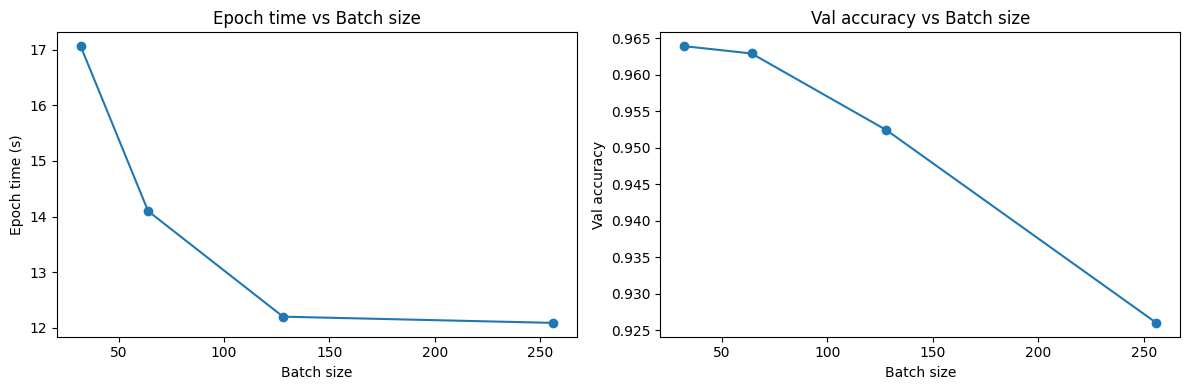

Running experiments on device: cuda
Running bs=32, amp=True ...
  -> time: 18.08s, val_acc: 0.9667
Running bs=64, amp=True ...
  -> time: 14.45s, val_acc: 0.9626
Running bs=128, amp=True ...
  -> time: 12.48s, val_acc: 0.9494
Running bs=256, amp=True ...
  -> time: 11.58s, val_acc: 0.9319
Saved experiment results to /content/experiments_results.pt


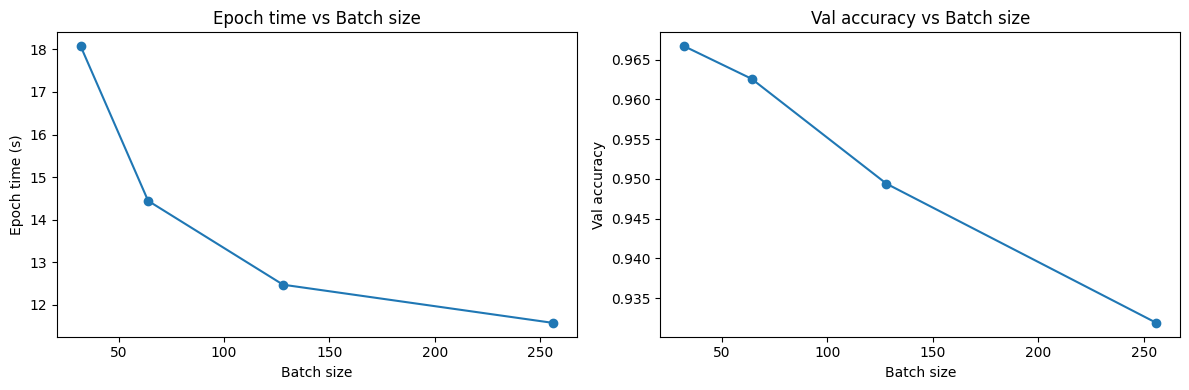

In [17]:
# Quick experiment runner: batch size sweep + optional AMP comparison.
def run_single_epoch(batch_size, use_amp=False, device=None):
    """Run 1 epoch training and validation to measure epoch time and val accuracy."""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MNIST_MLP().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    train_loader, val_loader, _, _ = get_mnist_loaders(batch_size, rank=0, world_size=1, data_dir='/content', num_workers=2)

    model.train()
    start = time.time()
    running_loss = 0.0
    running_acc  = 0.0
    count = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            with torch.autocast('cuda', enabled=True):
                out = model(data)
                loss = criterion(out, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * data.size(0)
        running_acc  += (out.argmax(dim=1) == target).float().sum().item()
        count += data.size(0)

    epoch_time = time.time() - start
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    return {
        'batch_size': batch_size, 'use_amp': use_amp,
        'epoch_time': epoch_time, 'val_acc': val_acc,
        'train_loss': running_loss/count, 'train_acc': running_acc/count
    }

def run_batch_sweep(batch_sizes=[32,64,128,256], do_amp=False):
    results = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running experiments on device:', device)
    for bs in batch_sizes:
        print(f'Running bs={bs}, amp={do_amp} ...')
        res = run_single_epoch(bs, use_amp=do_amp, device=device)
        results.append(res)
        print('  -> time: {:.2f}s, val_acc: {:.4f}'.format(res['epoch_time'], res['val_acc']))
    torch.save(results, RESULTS_FILE)
    print('Saved experiment results to', RESULTS_FILE)
    return results

def plot_experiment_results(results):
    if not results:
        print("[WARN] No results to plot."); return
    b = [r['batch_size'] for r in results]
    t = [r['epoch_time'] for r in results]
    a = [r['val_acc'] for r in results]
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(b, t, marker='o'); axs[0].set_xlabel('Batch size'); axs[0].set_ylabel('Epoch time (s)'); axs[0].set_title('Epoch time vs Batch size')
    axs[1].plot(b, a, marker='o'); axs[1].set_xlabel('Batch size'); axs[1].set_ylabel('Val accuracy'); axs[1].set_title('Val accuracy vs Batch size')
    plt.tight_layout();
    plt.show()

# Run without AMP
results_fp32 = run_batch_sweep([32, 64, 128, 256], do_amp=False)
plot_experiment_results(results_fp32)

# Run with AMP for comparison
results_amp = run_batch_sweep([32, 64, 128, 256], do_amp=True)
plot_experiment_results(results_amp)

## **Performance Benchmarking**

=== Single-process training ===
Running single-process training on cuda
Epoch 0 | train_loss=0.4445 train_acc=0.8724 | val_loss=0.1764 val_acc=0.9476 | time=12.16s | throughput=4934.95 img/s
Epoch 1 | train_loss=0.1652 train_acc=0.9520 | val_loss=0.1083 val_acc=0.9661 | time=11.95s | throughput=5021.69 img/s
Epoch 2 | train_loss=0.1164 train_acc=0.9650 | val_loss=0.0945 val_acc=0.9709 | time=12.27s | throughput=4888.20 img/s
Epoch 3 | train_loss=0.0912 train_acc=0.9725 | val_loss=0.0784 val_acc=0.9760 | time=12.08s | throughput=4966.99 img/s
Epoch 4 | train_loss=0.0734 train_acc=0.9771 | val_loss=0.0720 val_acc=0.9777 | time=12.31s | throughput=4873.44 img/s
[INFO] Saved history to /content/single_history.pt
[INFO] Saved model to /content/mnist_model.pth


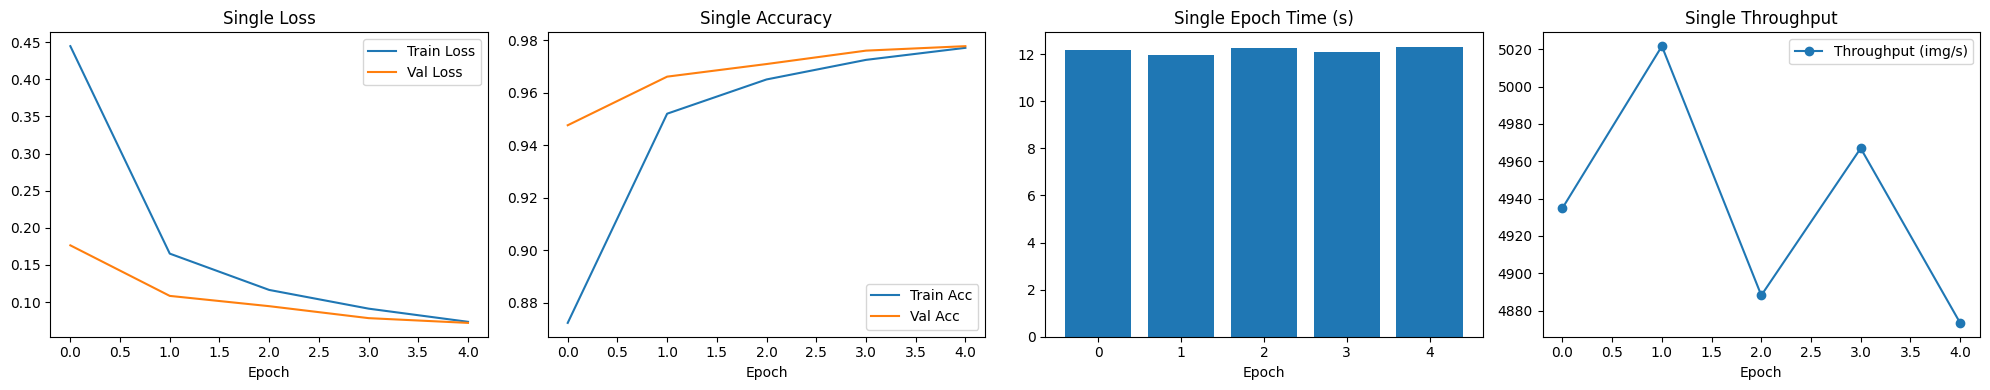

=== DDP training (Colab-safe) ===
Colab detected: simulating DDP with world_size=1 (single process).
[Rank0] Epoch 0 | train_loss=0.4409 train_acc=0.8723 | val_loss=0.1721 val_acc=0.9478 | time=12.38s | throughput=4846.15 img/s
[Rank0] Epoch 1 | train_loss=0.1628 train_acc=0.9508 | val_loss=0.1114 val_acc=0.9655 | time=12.58s | throughput=4768.95 img/s
[Rank0] Epoch 2 | train_loss=0.1157 train_acc=0.9651 | val_loss=0.0867 val_acc=0.9728 | time=12.53s | throughput=4787.88 img/s
[Rank0] Epoch 3 | train_loss=0.0886 train_acc=0.9726 | val_loss=0.0796 val_acc=0.9749 | time=12.66s | throughput=4740.59 img/s
[Rank0] Epoch 4 | train_loss=0.0727 train_acc=0.9783 | val_loss=0.0686 val_acc=0.9778 | time=12.24s | throughput=4902.37 img/s
[INFO] Saved history to /content/ddp_history_rank0.pt
[Rank0] Saved model to /content/mnist_model.pth
[INFO] Loaded history from /content/ddp_history_rank0.pt


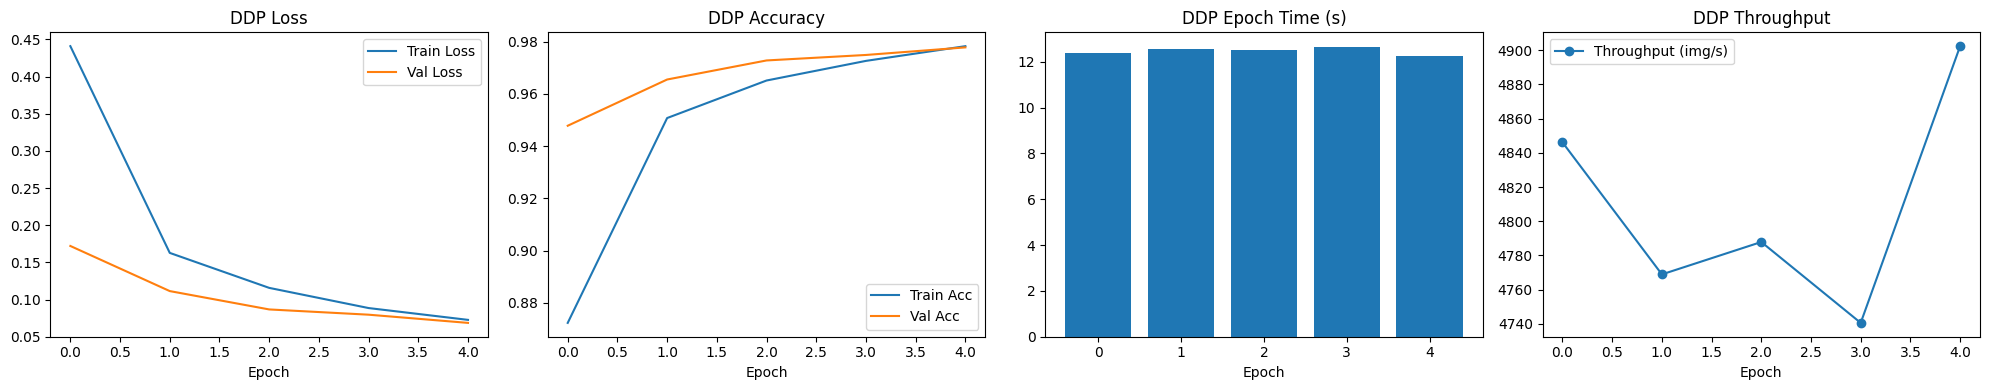

[INFO] Loaded history from /content/single_history.pt
[INFO] Loaded history from /content/ddp_history_rank0.pt


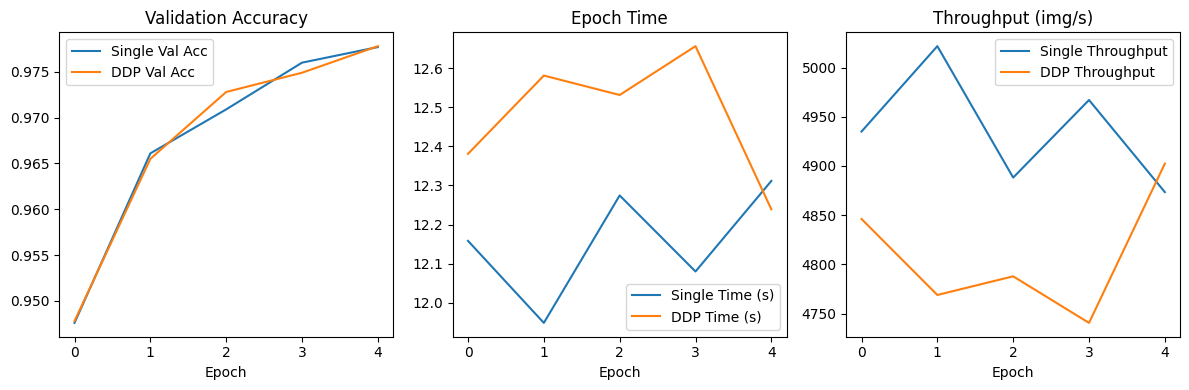

In [18]:
#9) Example usage (simple, clear)
# === Single-process demo ===
print("=== Single-process training ===")
single_hist = run_single_process(epochs=5, batch_size=128, use_amp=False)
plot_history(single_hist, title_prefix="Single")

# === DDP demo (Colab-safe) ===
print("=== DDP training (Colab-safe) ===")
run_ddp_demo_safe(world_size=2, epochs=5, batch_size=128, backend='gloo', port=12355)
ddp_hist = load_history(HIST_PATH_DDP)
if ddp_hist:
    plot_history(ddp_hist, title_prefix="DDP")

# === Side-by-side comparison ===
plot_compare(load_history(HIST_PATH_SINGLE), load_history(HIST_PATH_DDP))

## **Evaluation: confusion matrix & misclassified examples**

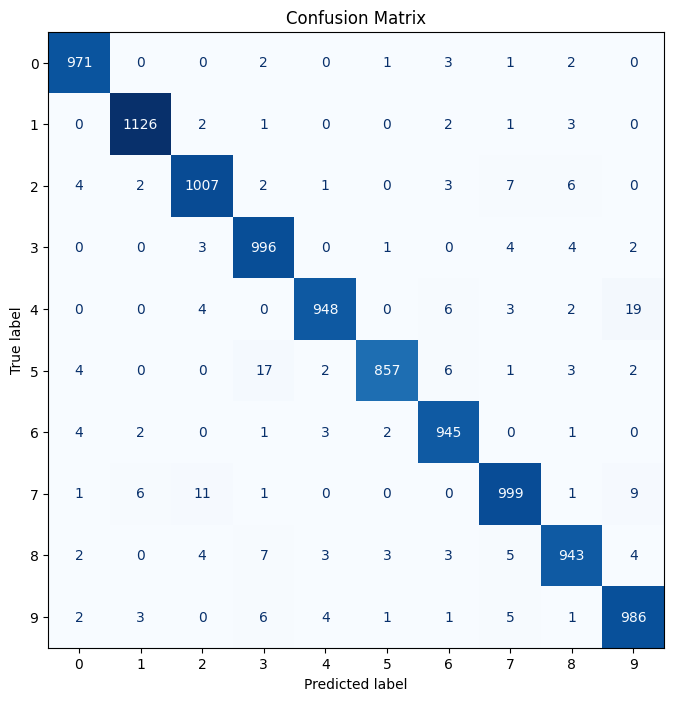

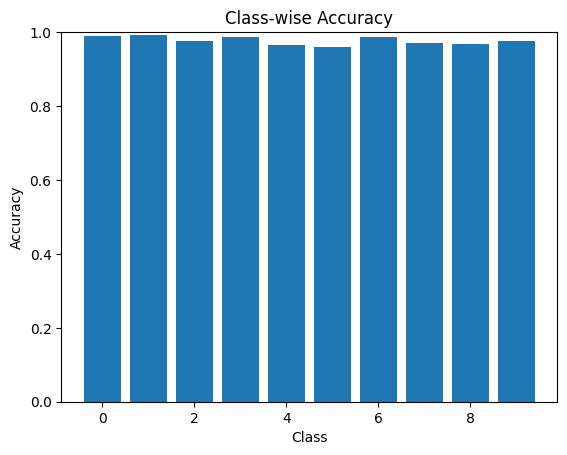

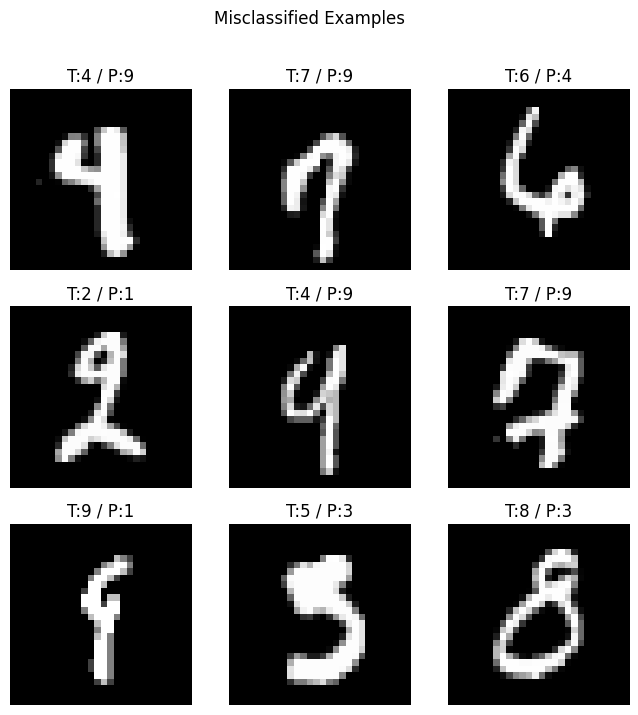

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNIST_MLP().to(device)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
else:
    print(f"[WARN] {MODEL_PATH} not found; run training first.")

_, val_loader, _, _ = get_mnist_loaders(batch_size=128, rank=0, world_size=1, data_dir='/content')

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()

class_acc = [(all_preds[all_labels==i] == i).mean() for i in range(10)]
plt.bar(range(10), class_acc)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.ylim(0,1)
plt.show()

# Show some misclassified examples
mis_idx = np.where(all_preds != all_labels)[0]
if len(mis_idx) > 0:
    samples = np.random.choice(mis_idx, min(9, len(mis_idx)), replace=False)
    plt.figure(figsize=(8,8))
    for i, idx in enumerate(samples, 1):
        img, true = val_loader.dataset[idx]
        pred = all_preds[idx]
        plt.subplot(3,3,i)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'T:{true} / P:{pred}')
        plt.axis('off')
    plt.suptitle('Misclassified Examples')
    plt.show()
else:
    print("No misclassifications to display.")
